<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/master/LWFMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys


In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 1446 (delta 81), reused 0 (delta 0), pack-reused 1311
Receiving objects: 100% (1446/1446), 991.93 KiB | 1.62 MiB/s, done.
Resolving deltas: 100% (923/923), done.


# Import packages

In [11]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Network

In [5]:
resNet = ResNet.resnet32(num_classes=100)
resNet = resNet.to(params.DEVICE)

In [6]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define DataSets

In [7]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [8]:
train_splits = trainDS.splits
test_splits = testDS.splits
print(train_splits)
print(test_splits)

[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.0, 95.0, 25.0, 47.0, 34.0, 52.0, 44.0, 72.0], [46.0, 79.0, 20.0, 28.0, 5.0, 71.0, 8.0, 18.0, 33.0, 15.0], [55.0, 29.0, 64.0, 31.0, 67.0, 7.0, 13.0, 14.0, 42.0, 6.0], [82.0, 2.0, 27.0, 16.0, 26.0, 3.0, 4.0, 1.0, 9.0, 0.0]]
[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.

# Useful plots

The function plotEpoch plots, at the end of each task, how accuracy and loss change during the training phase. It show

*   Validation and Training Accuracy
*   Validation and Training Loss

The function plotTask, for each task, how the accuracy on the validation set change when adding new tasks


In [9]:
def plotTask(pars_tasks):
  import numpy as np
  import matplotlib.pyplot as plt

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy', 'Loss'])
  plt.xlabel("Epoch")
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy', 'Loss'])
  plt.grid(True)
  plt.show()



# Train and evaluation phase

In [12]:
pars_tasks = []
test_indexes = []

for task in range(0, 100, params.TASK_SIZE):
  pars_tasks.insert(task, 0)

for task in range(0, 100, params.TASK_SIZE):

  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, train_transformer)
  test_dataset = Subset(testDS, test_indexes, test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle = True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle = True )

  if(task == 0):
    torch.save(resNet, 'resNet_task{0}.pt'.format(task))
  
  

  utils.trainfunction(task, train_loader, train_splits)
  param = utils.evaluationTest(task, test_loader, test_splits)
  pars_tasks[int(task/10)] = param #pars_task[i] = (accuracy, loss) at i-th task

task = 0 
train col =  [94 63 74 21 35 56 91 96 87 48]
train col =  [[94 63 74 21 35 56 91 96 87 48]]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


At step  0  and at epoch =  0  the loss is =  0.031964968889951706  and accuracy is =  0.169
At step  0  and at epoch =  1  the loss is =  0.023870963603258133  and accuracy is =  0.3538
At step  0  and at epoch =  2  the loss is =  0.028029445558786392  and accuracy is =  0.4366
At step  0  and at epoch =  3  the loss is =  0.03250391036272049  and accuracy is =  0.4782
At step  0  and at epoch =  4  the loss is =  0.031980786472558975  and accuracy is =  0.5164
At step  0  and at epoch =  5  the loss is =  0.02496189996600151  and accuracy is =  0.5498
At step  0  and at epoch =  6  the loss is =  0.008919685147702694  and accuracy is =  0.585
At step  0  and at epoch =  7  the loss is =  0.01897308975458145  and accuracy is =  0.6196
At step  0  and at epoch =  8  the loss is =  0.02042660117149353  and accuracy is =  0.6444
At step  0  and at epoch =  9  the loss is =  0.02938740700483322  and accuracy is =  0.6712
At step  0  and at epoch =  10  the loss is =  0.011121355928480625

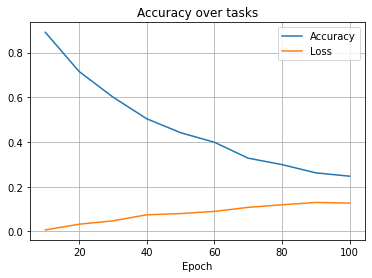

In [13]:
plotTask(pars_tasks)